In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Reading the dataset
data = pd.read_csv('E:/Copy of Rotten_Tomatoes_Movies3.csv', encoding='latin1')

# Categorizing columns according to their features
categorical_features = ['rating', 'genre', 'tomatometer_status']
text_features = ['movie_title', 'movie_info', 'critics_consensus', 'directors', 'writers', 'cast', 'studio_name']
numerical_features = ['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count']
target_column = 'audience_rating'

In [6]:
# Removing rows with missing values
data = data[categorical_features + text_features + numerical_features + [target_column]].dropna()

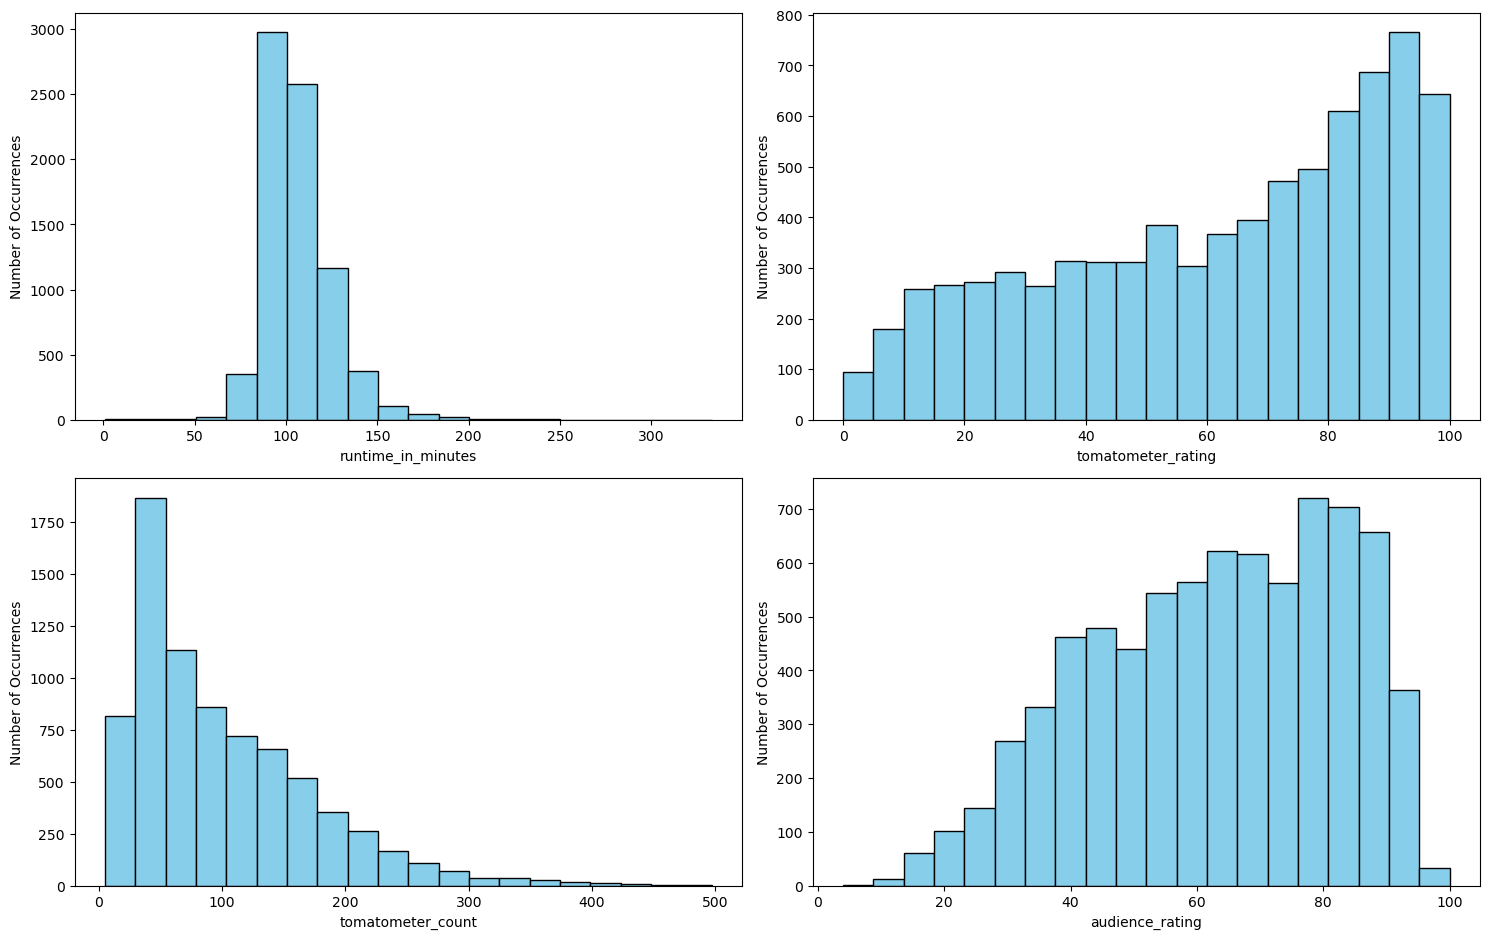

In [7]:
# Visualizing different parameters
numerical_columns = ['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 'audience_rating']


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, column in zip(axes.flatten(), numerical_columns):
    ax.hist(data[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Number of Occurrences', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


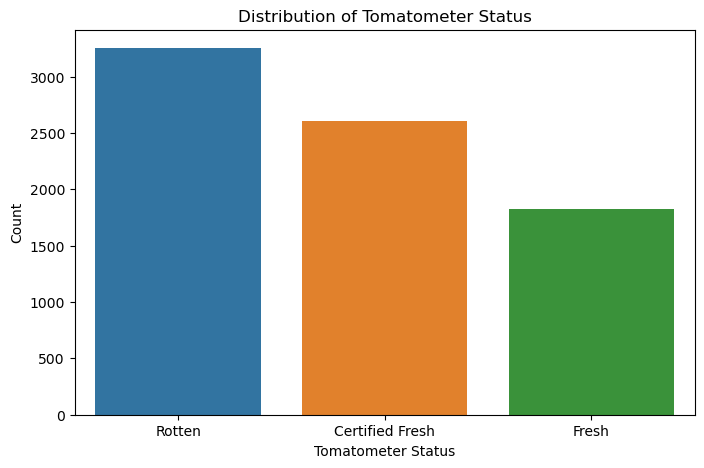

In [10]:
# Tomatometer Status plot 
plt.figure(figsize=(8, 5))
sns.countplot(x='tomatometer_status', data=data)
plt.title('Distribution of Tomatometer Status')
plt.xlabel('Tomatometer Status')
plt.ylabel('Count')
plt.show()

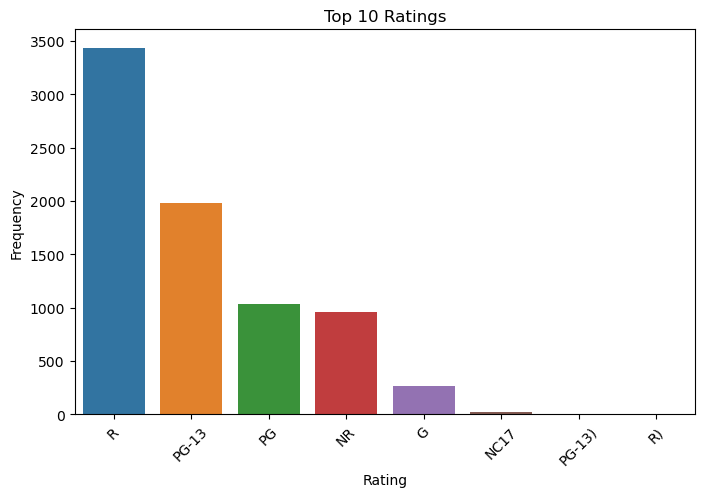

In [11]:
# Top 10 Ratings plot 
plt.figure(figsize=(8, 5))
top_ratings = data['rating'].value_counts().head(10)
sns.barplot(x=top_ratings.index, y=top_ratings.values)
plt.title('Top 10 Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

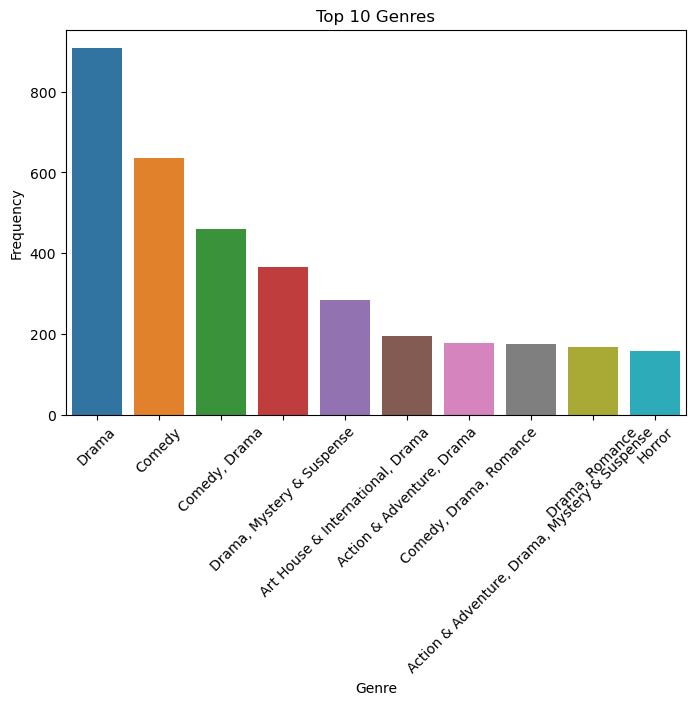

In [12]:
# Top 10 Genres Plot 
plt.figure(figsize=(8, 5))
top_genres = data['genre'].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Adding numerical features derived from text data columns
def extract_text_features(df, column):
    """Add sentiment and word count features for a text column."""
    df[f'{column}_sentiment'] = df[column].apply(lambda x: TextBlob(x).sentiment.polarity)
    df[f'{column}_word_count'] = df[column].apply(lambda x: len(x.split()))
    return df

#Extracting features from text data columns
for text_col in ['movie_info', 'critics_consensus']:
    data = extract_text_features(data, text_col)

# Combining genre and rating columns into a single interaction feature
data['genre_rating'] = data['genre'] + '_' + data['rating']

# Creating aggregated statistical features based on audience ratings
data['director_avg_rating'] = data.groupby('directors')['audience_rating'].transform('mean')
data['genre_avg_rating'] = data.groupby('genre')['audience_rating'].transform('mean')


In [16]:
data['cast_avg_rating'] = data.groupby('cast')['audience_rating'].transform('mean')
data['studio_avg_rating'] = data.groupby('studio_name')['audience_rating'].transform('mean')

# Replacing outliers in audience rating
upper_limit = data['audience_rating'].quantile(0.95)
data['audience_rating'] = np.clip(data['audience_rating'], None, upper_limit)


In [17]:
# Building Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english'), 'movie_info'),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('numerical', StandardScaler(), numerical_features + ['director_avg_rating', 'genre_avg_rating', 'cast_avg_rating', 'studio_avg_rating'])
    ],
    remainder='drop'
)


In [18]:
# Selecting Features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Building XGBoost model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.7,
        colsample_bytree=0.8,
        min_child_weight=5
    ))
])


In [20]:
# Training the pipeline
pipeline.fit(X_train, y_train)

# predictions
y_pred = pipeline.predict(X_test)


In [21]:
# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.9803362602537203
Root Mean Squared Error (RMSE): 0.9901193161703898
Mean Absolute Error (MAE): 0.5405219590245359


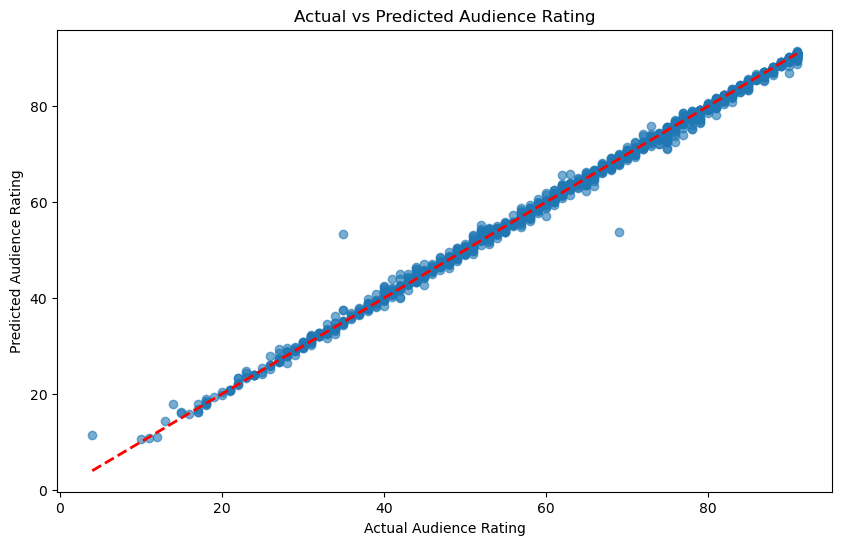

In [22]:
# Plot of Actual vs Predicted Audience Rating
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Audience Rating')
plt.ylabel('Predicted Audience Rating')
plt.title('Actual vs Predicted Audience Rating')
plt.show()